# Statistics for Experimental Physics
## Part II: Bayesian Statistics
### Assessed Problem Sheet 4

**Due: 11 December 2024**  
**Boris Leistedt** - B.LEISTEDT@IMPERIAL.AC.UK

Based on the material originally designed by Alan Heavens

Hand in by 5 pm Thursday 11th December. 

**Please submit a project-like report (PDF) with the results, and a copy of your code included. There are no page limits.**


## 1. Cosmology with Supernovae Ia

In this exercise, you will write **your own HMC code** to infer cosmological parameters from supernova Ia data. Do not use a package for the main HMC implementation, but you may use packages (e.g. corner.py) to display results.

**Objectives:**
1. Implement the cosmological distance-redshift relation for a flat universe
2. Build a Hamiltonian Monte Carlo sampler from scratch
3. Infer $\Omega_m$ (matter density) and $h$ (Hubble constant) from real supernova data (Pantheon+ dataset: 1701 supernovae)
4. Assess convergence using trace plots, autocorrelation, and effective sample size
5. Explore how HMC parameters affect sampling efficiency

**The Big Picture:** Type Ia supernovae are "standard candles" with known intrinsic brightness. By measuring their apparent brightness at different redshifts, we can map the distance-redshift relation, which depends on the Universe's composition ($\Omega_m$, $\Omega_v$, $h$). This same technique led to the 1998 Nobel Prize discovery that the Universe's expansion is accelerating, revealing the existence of dark energy.

### 1.1. Background and Theory

#### Type Ia Supernovae: Standard Candles for Cosmology

**Type Ia supernovae** are thermonuclear explosions of white dwarfs that reach the Chandrasekhar limit (~1.4 solar masses), making them excellent **standard candles**:
- Nearly uniform peak luminosity ($L \approx 10^{43}$ erg/s) after empirical corrections
- Visible to cosmological distances (billions of light-years)
- Led to the 1998 Nobel Prize discovery of accelerating cosmic expansion (Perlmutter, Schmidt, Riess)

#### Cosmological Framework

The Universe is expanding, causing **cosmological redshift**:
$$z \equiv \frac{\lambda_{\text{observed}} - \lambda_{\text{emitted}}}{\lambda_{\text{emitted}}} = \frac{a(t_{\text{now}})}{a(t_{\text{emission}})} - 1$$

where $a(t)$ is the scale factor ($a=1$ today). 

**Our goal is to measure the expansion rate and composition of the universe** by observing supernovae at different redshifts. Because supernovae are standard candles with known intrinsic brightness, measuring their apparent brightness (magnitude) tells us their distance. By mapping how distance varies with redshift for many supernovae, we can reconstruct the expansion history, which is governed by the cosmological parameters $\Omega_m$ and $h$. Different values of these parameters produce different distance-redshift curves—this is what allows us to infer cosmology from supernova observations.

The expansion is governed by the **Friedmann equation**:
$$H(z)^2 = H_0^2\left[\Omega_m(1+z)^3 + \Omega_k(1+z)^2 + \Omega_v\right]$$

**Parameters:**
- $H_0 = 100h$ km/s/Mpc: Hubble constant ($h \approx 0.7$, typical range 0.6-0.8)
- $\Omega_m \approx 0.3$: matter density parameter (typical range 0.2-0.4)
- $\Omega_v \approx 0.7$: dark energy density parameter
- $\Omega_k = 1 - \Omega_m - \Omega_v$: curvature parameter

We assume a **flat universe** ($\Omega_m + \Omega_v = 1$, $\Omega_k = 0$), well-supported by CMB observations.

#### Distance Measurements

The flux from a supernova of luminosity $L$ at **luminosity distance** $D_L$ is:
$$f = \frac{L}{4\pi D_L^2}$$

For a flat universe, $D_L$ is given by:
$$D_L(z) = 3000h^{-1}(1 + z) \int_0^z \frac{dz'}{\sqrt{\Omega_m(1 + z')^3 + 1 - \Omega_m}} \text{ Mpc}$$

Since HMC requires millions of likelihood evaluations, we use the **Pen (1999) analytical approximation** (accurate to <0.4%):
$$D_L(z; \Omega_m, h) = \frac{c}{H_0}(1 + z)\left[\eta(1, \Omega_m) - \eta\left(\frac{1}{1 + z}, \Omega_m\right)\right]$$

where $c = 299792.458$ km/s and:
$$\eta(a, \Omega_m) = 2\sqrt{s^3 + 1}\left[\frac{1}{a^4} - 0.1540\frac{s}{a^3} + 0.4304\frac{s^2}{a^2} + 0.19097\frac{s^3}{a} + 0.066941s^4\right]^{-1/8}$$

with $s^3 = (1 - \Omega_m)/\Omega_m$ and $a = 1/(1+z)$ (valid for $0.2 \leq \Omega_m \leq 1$).

Astronomers measure brightness using **magnitudes** ($m = -2.5\log_{10}f + \text{const}$). The **distance modulus** is:
$$\mu = m - M = 5\log_{10}\left(\frac{D_L}{\text{Mpc}}\right) + 25$$

Factoring out $h$ using $D_L^* \equiv D_L(h=1)$:
$$\mu(z; \Omega_m, h) = 25 - 5\log_{10} h + 5\log_{10}\left(\frac{D_L^*}{\text{Mpc}}\right)$$

where $h$ produces a vertical shift and $\Omega_m$ affects the curve shape.



### 1.2. Data

The data file (from the 'Pantheon+' sample - see https://arxiv.org/abs/2112.03863 for more detail) consists of data from 1701 supernovae, with a redshift and distance modulus $\mu$ for each supernova. 

The file `Pantheon+SH0ES.dat` (from Teams or Blackboard) contains the data:
- `zHD`: redshift you should use
- `MU_SH0ES`: distance modulus

The covariance matrix $C$ is provided in `Pantheon+SH0ES_STAT+SYS.cov.txt` (from Teams or Blackboard).
It is a square symmetric matrix N x N.
The file provided contains a vector (the first row is the size N) which you can just reshape to N x N.

The files can also be downloaded here:
- https://www.dropbox.com/scl/fi/n67of2kwtmabb2vahk36m/Pantheon-SH0ES.dat?rlkey=mw210zbna7b0pxs4ptj2gdivl&dl=0
- https://www.dropbox.com/scl/fi/ncafbjkwh5w83hehs6p0u/Pantheon-SH0ES_STAT-SYS.cov.txt.zip?rlkey=ruxgi74dkz1hcfehxdl4jfns9&dl=0 

### 1.3. Exercise

Write your own HMC code to infer $h$ and $\Omega_m$ from the supernova dataset, assuming the Universe is flat and the errors are Gaussian.

**Requirements:**

- Nearby supernovae have redshifts significantly altered by 'peculiar velocities', not associated with the general expansion of the Universe. **Discard supernovae with $z < 0.01$.**
- $h$ and $\Omega_m$ are positive, and have values of the rough order of unity
- Assume uniform priors on the parameters (so you will sample from the likelihood)
- Explore visually (with trace plots) the chain, and compute and report the acceptance rate
- Choose a suitable burn-in and say why you chose it
- Compute the average value of the parameters under the posterior distribution, and their variances and covariance
- Compute and display the correlation function of the chain. Compute the acceptance rate and the effective number of samples, using the formula in the lectures. Explore how these changes as the parameters of the HMC are varied

### My Report - Mihir Koka

---

## Bayesian Inference of Cosmological Parameters from Supernova Ia Data

**Student:** Mihir Koka  
**Course:** Statistics for Experimental Physics (Part II: Bayesian Statistics)  
**Date:** December 2024

---
### Executive Summary

This report implements a Hamiltonian Monte Carlo (HMC) sampler from scratch to infer cosmological parameters $\Omega_m$ (matter density) and $h$ (reduced Hubble constant) from the Pantheon+ Type Ia supernova dataset (1701 SNe). Key findings:

- Posterior mean: $\Omega_m = \ldots$, $h = \ldots$ (to be filled after running)
- Effective sample size: $N_{\text{eff}} = \ldots$
- Acceptance rate: $\ldots\%$

The analysis demonstrates [brief interpretation of results].

---

### 1. Introduction

Type Ia supernovae are cosmological "standard candles" used to measure cosmic expansion. This project:
1. Implements the Pen (1999) distance-redshift approximation
2. Builds an HMC sampler without external MCMC packages
3. Diagnoses convergence via trace plots, autocorrelation, and ESS
4. Explores tuning parameter effects ($\epsilon$, $L$)

---

<div style="border:2px solid #4CAF50; padding:10px; background-color:#f9f9f9;">

**Note: AI Declaration**

AI was used in the following ways in this assignment:  
- formatting my handwriting to LaTeX
- plotting functions (copilot tab complete)
- tables to output values, to format them nicely

</div>


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.set_default_dtype(torch.float64)
from pathlib import Path

# Add your imports here

### 2. Data Preparation

**Dataset:** Pantheon+ (1701 SNe) filtered to $z \geq 0.01$ (removes peculiar velocity contamination)

In [3]:
# Load supernova data
# Filter z < 0.01
# Your code here

DATA_DIR = Path(".")
SN_FILE = DATA_DIR/"Pantheon+SH0ES.dat"
COV_FILE = DATA_DIR / "Pantheon+SH0ES_STAT+SYS.cov.txt"

df = pd.read_csv(SN_FILE, delim_whitespace=True)
expected_columns = {"zHD", "MU_SH0ES"}
print(set(df.columns).issuperset(expected_columns))

# Discard nearby SNe with z < 0.01, preserve original ordering
mask = df["zHD"].to_numpy() >= 0.01
idx = np.where(mask)[0]

df_f = df.loc[mask].reset_index(drop=True)
z_data = df_f["zHD"].to_numpy(dtype=np.float64)
mu_data = df_f["MU_SH0ES"].to_numpy(dtype=np.float64)

print(f"Loaded {len(df)} SNe; kept {len(z_data)} with z >= 0.01")
print(f"Data columns: {list(df.columns)}")

True
Loaded 1701 SNe; kept 1590 with z >= 0.01
Data columns: ['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL', 'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF', 'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC', 'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB', 'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b', 'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD']


C:\Users\Mihir Koka\AppData\Local\Temp\ipykernel_45600\3155238785.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(SN_FILE, delim_whitespace=True)


Symmetrize: The file should store a symmetric matrix, but floating-point I/O can introduce tiny asymmetries. Forcing symmetry prevents numerical issues.

Jitter: Real covariance matrices can be nearly singular (almostzero eigenvalues) due to correlated systematic errors. Adding 1e-10 * mean ensures Cholesky doesn't fail. This is standard practice

Cholesky: We need to compute r^T C^-1 r millions of times. Direct inversion is:
- Slower (O(N³) time complexity per sample)
- Numerically unstable\
So we use a faster triangular solve, cholesky is needed to make our HMC efficient
It gives us a lower trianglar matrix L s.t C = L L^T
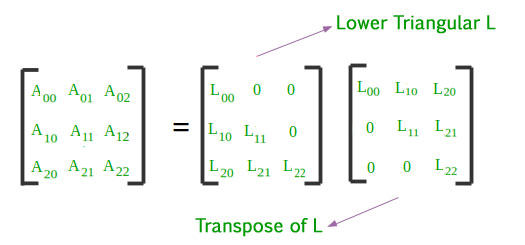

In [4]:
# Load covariance matrix and extract corresponding subset after filtering
def load_covariance_vector_file(path: Path):
    """
    Load covariance from a file that stores N on the first line,
    followed by N*N values (vectorized). Returns C (N x N).
    """
    with open(path, "r") as f:
        first_line = f.readline().strip()
        N = int(first_line)
        flat = np.loadtxt(f, dtype=np.float64)
    
    assert flat.size == N * N, f"Expected {N*N} elements, got {flat.size}"
    C = flat.reshape(N, N)
    return C

C = load_covariance_vector_file(COV_FILE)

# Subset to match the filtered data indices
C_sub = C[np.ix_(idx, idx)].astype(np.float64)

# Symmetrize and add tiny jitter
C_sub = (C_sub + C_sub.T) / 2.0
jitter = 1e-10 * np.mean(np.diag(C_sub))
C_sub_j = C_sub + np.eye(C_sub.shape[0]) * jitter

# Cholesky decomposition
L = np.linalg.cholesky(C_sub_j)

print(f"Covariance original shape: {C.shape}, subset shape: {C_sub.shape}")

# Prepare torch tensors
z_t = torch.from_numpy(z_data)
mu_t = torch.from_numpy(mu_data)
C_chol_t = torch.from_numpy(L)

Covariance original shape: (1701, 1701), subset shape: (1590, 1590)


#### Implement the theoretical model (Pen 1999 formula)
### 3. Theoretical Model
Using the constants from the paper as seen here 
[link to paper](https://iopscience.iop.org/article/10.1086/313167/pdf)


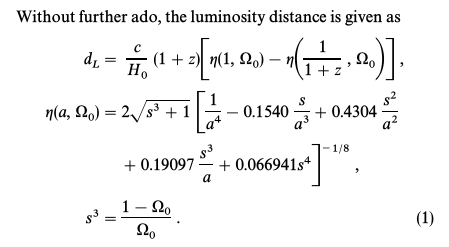

In [5]:
def eta(a, Omega_m):
    """
    Helper function for Pen (1999) formula.
    
    Parameters:
    -----------
    a : float or array
        Scale factor (a = 1/(1+z))
    Omega_m : float
        Matter density parameter
    
    Returns:
    --------
    eta : float or array
    """
    s3 =(1.0 - Omega_m) / Omega_m
    s = s3**(1.0/3.0)

    #numerator
    term1 = 1.0 / (a**4)
    term2 = 0.1540 * s / (a**3)
    term3 = 0.4304 * (s**2) / (a**2)
    term4 = 0.19097 * (s**3) / a
    term5 = 0.066941 * (s**4)

    poly = term1 - term2 + term3 + term4 + term5
    
    eta_val = 2.0 * torch.sqrt(s3 + 1.0) * (poly ** (-1.0/8.0))
    return eta_val

def luminosity_distance_star(z, Omega_m):
    """
    Calculate D_L^* (luminosity distance with h=1 factored out) using Pen (1999).
    
    Parameters:
    -----------
    z : float or array
        Redshift
    Omega_m : float
        Matter density parameter
    
    Returns:
    --------
    D_L_star : float or array
        Luminosity distance in Mpc (with h=1)
    """
    c_km_s = 299792.458  # Speed of light in km/s
    
    # Compute eta at a=1 and a=1/(1+z)
    eta_1 = eta(torch.tensor(1.0, dtype=torch.float64), Omega_m)
    a_z = 1.0 / (1.0 + z)
    eta_z = eta(a_z, Omega_m)
    
    # D_L^* in Mpc
    D_L_star = (c_km_s / 100.0) * (1.0 + z) * (eta_1 - eta_z)
    return D_L_star

def distance_modulus(z, Omega_m, h):
    """
    Calculate theoretical distance modulus.
    
    Parameters:
    -----------
    z : float or array
        Redshift
    Omega_m : float
        Matter density parameter
    h : float
        Reduced Hubble constant
    
    Returns:
    --------
    mu : float or array
        Distance modulus
    """
    D_L_star = luminosity_distance_star(z, Omega_m)

    mu = 25.0 - 5.0 * torch.log10(h) + 5.0 * torch.log10(D_L_star)
    return mu


# === VALIDATION TEST ===
# Expected: Omega_m=0.3, h=0.7, z=0.5 → mu ≈ 42.3 mag (Pen 1999 approximation)
z_test = torch.tensor([0.5], dtype=torch.float64)
Omega_m_test = torch.tensor(0.3, dtype=torch.float64)
h_test = torch.tensor(0.7, dtype=torch.float64)

mu_test = distance_modulus(z_test, Omega_m_test, h_test)
print(f"Test: z={z_test.item():.1f}, Omega_m={Omega_m_test.item():.1f}, h={h_test.item():.1f}")
print(f"  → mu = {mu_test.item():.2f} mag (expect ~42.3)")

# Test on array of redshifts (should be monotonically increasing)
z_array = torch.tensor([0.1, 0.5, 1.0, 1.5], dtype=torch.float64)
mu_array = distance_modulus(z_array, Omega_m_test, h_test)
print(f"\nDistance moduli for z={z_array.numpy()}:")
for z_val, mu_val in zip(z_array, mu_array):
    print(f"  z={z_val:.1f} → μ={mu_val:.2f} mag")

Test: z=0.5, Omega_m=0.3, h=0.7
  → mu = 42.27 mag (expect ~42.3)

Distance moduli for z=[0.1 0.5 1.  1.5]:
  z=0.1 → μ=38.32 mag
  z=0.5 → μ=42.27 mag
  z=1.0 → μ=44.10 mag
  z=1.5 → μ=45.19 mag


Statistics seems to be within expectations and the magnitude is increasing smoothly. Validation done.

#### Implement the likelihood and its gradient
### 4. HMC Implementation

In [6]:
def log_likelihood(params, z_data, mu_data, C_chol):
    """
    Calculate log-likelihood for supernova data.
    
    Parameters:
    -----------
    params : torch.Tensor
        [Omega_m, h] (both must be positive)
    z_data : torch.Tensor
        Redshift data
    mu_data : torch.Tensor
        Observed distance modulus
    C_chol : torch.Tensor
        Cholesky factor L (lower triangular) where C = L L^T
    
    Returns:
    --------
    log_L : torch.Tensor (scalar)
        Log-likelihood value
    """
    Omega_m, h = params
    
    # Compute theoretical predictions
    mu_theory = distance_modulus(z_data, Omega_m, h)
    
    # Residuals
    r = mu_data - mu_theory
    
    # Solve L y = r (reshape r to column vector for solve_triangular)
    y = torch.linalg.solve_triangular(C_chol, r.unsqueeze(1), upper=False).squeeze()
    
    # chi^2 = r^T C^{-1} r = y^T y
    chi2 = torch.dot(y, y)
    
    # Log-likelihood (ignoring constant terms)
    log_L = -0.5 * chi2
    
    return log_L


def gradient_log_likelihood(params, z_data, mu_data, C_chol):
    """
    Calculate gradient using PyTorch autograd.
    
    Parameters:
    -----------
    params : torch.Tensor
        [Omega_m, h] with requires_grad=True
    z_data : torch.Tensor
        Redshift data
    mu_data : torch.Tensor
        Distance modulus data
    C_chol : torch.Tensor
        Cholesky factor
    
    Returns:
    --------
    grad : torch.Tensor
        Gradient [d(log L)/d(Omega_m), d(log L)/dh]
    """
    # Enable gradient tracking for autograd
    params_grad = params.clone().detach().requires_grad_(True)
    
    # Compute log-likelihood
    log_L = log_likelihood(params_grad, z_data, mu_data, C_chol)
    
    # Backpropagate to get gradients
    log_L.backward()
    
    return params_grad.grad.clone()


# === VALIDATION TEST ===
# Test likelihood at true cosmology (should be close to maximum)
params_test = torch.tensor([0.3, 0.7], dtype=torch.float64)
log_L_test = log_likelihood(params_test, z_t, mu_t, C_chol_t)
print(f"\nLog-likelihood at (Ωₘ=0.3, h=0.7): {log_L_test.item():.2f}")

# Test gradient (should be close to zero at maximum likelihood)
grad_test = gradient_log_likelihood(params_test, z_t, mu_t, C_chol_t)
print(f"Gradient at (Ωₘ=0.3, h=0.7): {grad_test.numpy()}")
print(f"Gradient magnitude: {torch.norm(grad_test).item():.2e}")


Log-likelihood at (Ωₘ=0.3, h=0.7): -1165.89
Gradient at (Ωₘ=0.3, h=0.7): [ 2525.49044828 25047.9376672 ]
Gradient magnitude: 2.52e+04


The log-likelihood indicates a resonable model -> data agreement. While the large magnitude shows that (Ωₘ=0.3, h=0.7) is not at the max likelihood. The gradient is pointing toward better fit params. This validates that out gradient comp is working as expected and will guide the HMC towards the true posterior.

#### Implement HMC sampler

Implement the Hamiltonian Monte Carlo algorithm, including:
- Leapfrog integrator for Hamiltonian dynamics
- Metropolis acceptance step
- Main HMC loop

In [9]:
def leapfrog(q, p, epsilon, L, grad_log_prob, *args):
    """
    Leapfrog integrator for Hamiltonian dynamics.
    
    Parameters:
    -----------
    q : torch.Tensor
        Current position (parameters)
    p : torch.Tensor
        Current momentum
    epsilon : float
        Step size
    L : int
        Number of leapfrog steps
    grad_log_prob : function
        Function to calculate gradient of log probability
    *args : additional arguments
        Additional arguments to pass to grad_log_prob
    
    Returns:
    --------
    q_new : torch.Tensor
        New position
    p_new : torch.Tensor
        New momentum
    """
    q = q.clone()
    p = p.clone()
    
    # Half step for momentum at the beginning
    p = p + 0.5 * epsilon * grad_log_prob(q, *args)
    
    # Alternate full steps for position and momentum
    for i in range(L - 1):
        q = q + epsilon * p
        p = p + epsilon * grad_log_prob(q, *args)
    
    # Full step for position at the end
    q = q + epsilon * p
    
    # Half step for momentum at the end
    p = p + 0.5 * epsilon * grad_log_prob(q, *args)
    
    # Negate momentum for reversibility
    p = -p
    
    return q, p


def hmc_sampler(initial_params, n_samples, epsilon, L, log_prob, grad_log_prob, *args):
    """
    Hamiltonian Monte Carlo sampler.
    
    Parameters:
    -----------
    initial_params : torch.Tensor
        Initial parameter values [Omega_m, h]
    n_samples : int
        Number of samples to generate
    epsilon : float
        Step size for leapfrog integrator
    L : int
        Number of leapfrog steps per iteration
    log_prob : function
        Log probability function
    grad_log_prob : function
        Gradient of log probability
    *args : additional arguments
        Additional arguments to pass to log_prob and grad_log_prob
    
    Returns:
    --------
    samples : np.ndarray
        MCMC samples (n_samples x n_params)
    acceptance_rate : float
        Fraction of proposals accepted
    """
    n_params = len(initial_params)
    samples = np.zeros((n_samples, n_params))
    n_accepted = 0
    
    # Initialize
    q = initial_params.clone()
    
    for i in range(n_samples):
        # Sample momentum from standard normal
        p = torch.randn(n_params, dtype=torch.float64)
        
        # Store current state
        q_current = q.clone()
        p_current = p.clone()
        
        # Compute current Hamiltonian
        current_log_prob = log_prob(q_current, *args)
        current_K = 0.5 * torch.dot(p_current, p_current)
        current_H = -current_log_prob + current_K
        
        # Leapfrog integration
        q_proposed, p_proposed = leapfrog(q_current, p_current, epsilon, L, grad_log_prob, *args)
        
        # Compute proposed Hamiltonian
        proposed_log_prob = log_prob(q_proposed, *args)
        proposed_K = 0.5 * torch.dot(p_proposed, p_proposed)
        proposed_H = -proposed_log_prob + proposed_K
        
        # Metropolis acceptance
        log_accept_ratio = current_H - proposed_H
        
        if torch.log(torch.rand(1, dtype=torch.float64)) < log_accept_ratio:
            q = q_proposed
            n_accepted += 1
        
        # Store sample
        samples[i] = q.numpy()
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"Sample {i+1}/{n_samples}, acceptance rate: {n_accepted/(i+1):.2%}")
    
    acceptance_rate = n_accepted / n_samples
    
    return samples, acceptance_rate


# === VALIDATION TEST ===
# Quick test with 10 samples
print("Testing HMC with 10 samples...")
initial_test = torch.tensor([0.3, 0.7], dtype=torch.float64)
samples_test, acc_test = hmc_sampler(
    initial_test, 
    10,  # n_samples (positional, no keyword)
    1e-4,  # epsilon (positional, no keyword)
    20,  # L (positional, no keyword)
    log_likelihood,  # log_prob (positional, no keyword)
    gradient_log_likelihood,  # grad_log_prob (positional, no keyword)
    z_t, mu_t, C_chol_t  # *args (positional, already correct)
)
print(f"\nTest completed. Acceptance rate: {acc_test:.2%}")
print(f"Sample mean: Ωₘ={samples_test[:, 0].mean():.3f}, h={samples_test[:, 1].mean():.3f}")

Testing HMC with 10 samples...

Test completed. Acceptance rate: 100.00%
Sample mean: Ωₘ=0.308, h=0.737


#### Run HMC sampler

In [ ]:
# Set HMC parameters
# initial_params = [Omega_m_init, h_init]
# n_samples = ...
# epsilon = ...
# L = ...

# Run HMC
# samples, acceptance_rate = hmc_sampler(...)

# Your code here

#### Trace plots and acceptance rate

Create trace plots to visualize the MCMC chain and report the acceptance rate.

In [ ]:
# Create trace plots
# Your code here

#### Burn-in and posterior analysis

Choose an appropriate burn-in period and compute posterior statistics.

In [ ]:
# Choose burn-in based on trace plots
# burn_in = ...

# Remove burn-in samples
# samples_post_burnin = samples[burn_in:]

# Compute posterior mean
# mean_Omega_m = ...
# mean_h = ...

# Compute posterior variance
# var_Omega_m = ...
# var_h = ...

# Compute posterior covariance
# cov_matrix = ...

# Your code here

#### Autocorrelation function and effective sample size

Compute and plot the autocorrelation function, then calculate the effective number of independent samples.

In [ ]:
# Compute autocorrelation function
# Your code here

# Plot autocorrelation
# Your code here

# Compute effective sample size
# Use formula from lectures: N_eff = N / (1 + 2*sum(rho_k))
# Your code here

#### Exploration of HMC parameter effects

Systematically explore how the step size $\epsilon$ and number of leapfrog steps $L$ affect:
- Acceptance rate
- Effective sample size
- Computational efficiency

In [ ]:
# Vary epsilon and L systematically
# For each combination, run HMC and compute acceptance rate and N_eff
# Your code here

#### Visualization of results

Create visualizations of the posterior distribution.

In [ ]:
# Create 2D posterior plot (contours or scatter)
# Can use corner.py package: corner.corner(samples_post_burnin, labels=[r'$\Omega_m$', r'$h$'])
# Your code here

### 1.4. Optional Extension

- Write and apply a Gelman-Rubin convergence test, and deduce roughly how long the chains should be for convergence.

In [ ]:
# Optional: Gelman-Rubin convergence test
# Run multiple chains from different starting points
# Compute R-hat statistic
# Your code here